# Preprocessing & Training
## Predicting Rates of Chronic Absenteeism

### Imports 

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/interim'
os.chdir(path)

In [3]:
attendance = pd.read_csv('attendance_with_nextYear.csv')
attendance.head()

DBN                School Name               Grade     Year  \
0  01M015  P.S. 015 Roberto Clemente          All Grades  2013-14   
1  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2013-14   
2  01M015  P.S. 015 Roberto Clemente                  0K  2013-14   
3  01M015  P.S. 015 Roberto Clemente                   1  2013-14   
4  01M015  P.S. 015 Roberto Clemente                   2  2013-14   

  Demographic Category Demographic Variable  # Total Days  # Days Absent  \
0         All Students         All Students         34803         2783.0   
1         All Students         All Students          4711          560.0   
2         All Students         All Students          7073          659.0   
3         All Students         All Students          6739          525.0   
4         All Students         All Students          3988          308.0   

   # Days Present  % Attendance  # Contributing 20+ Total Days  \
0         32020.0          92.0                          216.0   
1          4151.0          88.1                           30.0   
2          6414.0          90.7                           44.0   
3          6214.0          92.2                           42.0   
4          3680.0          92.3                           25.0   

   # Chronically Absent  % Chronically Absent  Next Year % Chronically Absent  
0                  58.0                  26.9                            23.4  
1                  16.0                  53.3                            65.2  
2                  13.0                  29.5                            30.0  
3                  13.0                  31.0                            18.8  
4                   5.0                  20.0                            21.9

In [4]:
#drop highly correlated variables idenfiied in EDA, retained variables that make the model more generalizable 
    #as the remaining values more schools would have data on

#drop # Total Days and #Contributing 20+ Total Days (are highly correlated with # Days Present)
#drop #Chronically Absent (is highly correlated with # Days Absent)
#Drop Demographic Category as Demographic Variable contains all this information and they are highly correlated
attendance = attendance.drop(columns=['# Contributing 20+ Total Days','# Total Days', '# Chronically Absent', 'Demographic Category',])
attendance.head()

DBN                School Name               Grade     Year  \
0  01M015  P.S. 015 Roberto Clemente          All Grades  2013-14   
1  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2013-14   
2  01M015  P.S. 015 Roberto Clemente                  0K  2013-14   
3  01M015  P.S. 015 Roberto Clemente                   1  2013-14   
4  01M015  P.S. 015 Roberto Clemente                   2  2013-14   

  Demographic Variable  # Days Absent  # Days Present  % Attendance  \
0         All Students         2783.0         32020.0          92.0   
1         All Students          560.0          4151.0          88.1   
2         All Students          659.0          6414.0          90.7   
3         All Students          525.0          6214.0          92.2   
4         All Students          308.0          3680.0          92.3   

   % Chronically Absent  Next Year % Chronically Absent  
0                  26.9                            23.4  
1                  53.3                            65.2  
2                  29.5                            30.0  
3                  31.0                            18.8  
4                  20.0                            21.9

In [5]:
#definte mean and std deviation of target variable
std = np.std(attendance['Next Year % Chronically Absent'])
mean = np.mean(attendance['Next Year % Chronically Absent'])

In [6]:
#Turn chronic absenteeism into categorical variable
    #High = 1 stand deviations above mean
    #Med = +/- 1 std from mean
    #Low = 1 std dev below mean
    
# defining function to check price 
def fun(num): 
  
    if num< (mean - std): 
        return "Low"
  
    elif num>= (mean - std) and num <= (mean + std): 
        return "Medium"
    
    elif num > (mean+ std):
        return "High"
  
    else: 
        return np.nan

In [7]:
# passing function to apply and storing returned series as new column
attendance['Chronically_Absent_Next_Year'] = attendance['Next Year % Chronically Absent'].apply(fun) 

In [8]:
#check NaNs in data set, look this subset by year (are these schools that closed??)
check_nans = attendance[attendance['Next Year % Chronically Absent'].isnull() == True]
check_nans['Year'].value_counts()/len(check_nans)*100

2018-19    68.677238
2013-14     6.433159
2016-17     6.327445
2017-18     6.304697
2014-15     6.239128
2015-16     6.018333
Name: Year, dtype: float64

In [9]:
#define functions to get NaNs as % 
def NaNs_as_percent(dataframe):
    '''show % NaNs for each column'''
    print(dataframe.isna().sum()/len(dataframe)*100)

In [10]:
NaNs_as_percent(attendance)

DBN                                0.000000
School Name                        0.000000
Grade                              0.000000
Year                               0.000000
Demographic Variable               0.000000
# Days Absent                      0.000000
# Days Present                     0.000000
% Attendance                       0.000000
% Chronically Absent               0.000000
Next Year % Chronically Absent    24.768982
Chronically_Absent_Next_Year      24.768982
dtype: float64


In [11]:
#check value counts by year
check_nans.Year.value_counts()/len(check_nans.Year)*100

2018-19    68.677238
2013-14     6.433159
2016-17     6.327445
2017-18     6.304697
2014-15     6.239128
2015-16     6.018333
Name: Year, dtype: float64

In [12]:
#examine one year besides 2018-19 (which was the expected)
check_nans[check_nans.Year == '2013-14'].head()

DBN                                        School Name  \
126  01M301              Technology, Arts, and Sciences Studio   
142  01M345  Collaborative Academy of Science, Technology, ...   
320  02M104                            J.H.S. 104 Simon Baruch   
329  02M111                            P.S. 111 Adolph S. Ochs   
352  02M126                         P.S. 126 Jacob August Riis   

                  Grade     Year Demographic Variable  # Days Absent  \
126                   7  2013-14         All Students          944.0   
142                   7  2013-14         All Students          960.0   
320                   8  2013-14         All Students         3020.0   
329                   6  2013-14         All Students          801.0   
352  PK in K-12 Schools  2013-14         All Students          727.0   

     # Days Present  % Attendance  % Chronically Absent  \
126          8451.0          90.0                  37.0   
142         11258.0          92.1                  30.1   
320         63922.0          95.5                  12.2   
329          9631.0          92.3                  29.5   
352          7999.0          91.7                  25.5   

     Next Year % Chronically Absent Chronically_Absent_Next_Year  
126                             NaN                          NaN  
142                             NaN                          NaN  
320                             NaN                          NaN  
329                             NaN                          NaN  
352                             NaN                          NaN

In [13]:
#check percent of data that has NaNs not in the expected year of 2018-19
print(len(check_nans[check_nans.Year != '2018-19'])/len(attendance)*100)
print(len(attendance))

7.758329245495645
603416


It seems that the NaNs in `Next Year % Chronically Absent` aren't just in 2018-19 as expected. There are around 6% of data each year that does not have next year's data. Some of the schools I looked into were closed or had name changes. This could possibly be due to inconsistent naming of the schools year to year led to a calculation error for `Next Year % Chronically Absent` or these school did not have data for that subset of students the following year. I will have to dig further into why this may be occuring. This makes up around 7.8% of data.

In [14]:
##? (maybe just keep categorical) Turn year into year start (ie. 2013) and year end (ie. 2014) so it can be an integer for ML later, steps:
    #Start column - Strip anything after 4 strings, 
    #End column - start column + 1

## Feature Creation

In [15]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603416 entries, 0 to 603415
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   DBN                             603416 non-null  object 
 1   School Name                     603416 non-null  object 
 2   Grade                           603416 non-null  object 
 3   Year                            603416 non-null  object 
 4   Demographic Variable            603416 non-null  object 
 5   # Days Absent                   603416 non-null  float64
 6   # Days Present                  603416 non-null  float64
 7   % Attendance                    603416 non-null  float64
 8   % Chronically Absent            603416 non-null  float64
 9   Next Year % Chronically Absent  453956 non-null  float64
 10  Chronically_Absent_Next_Year    453956 non-null  object 
dtypes: float64(5), object(6)
memory usage: 50.6+ MB


Currently there are several categorical variables - over 1600 unique schools, 15 grades, 6 years and 14 demographic variables).


To deal with DBN (District Borough Number) and School Name we will split DBN into it's 3 components see [explanation of DBN](https://teachnyc.zendesk.com/hc/en-us/articles/360053601831-What-is-a-DBN-District-Borough-Number-) here. They are: District Number, Borough Code, and School Number. Then we can retain district number and borough code while droping school number, and borough code. This will make our dummy variables more manageable and our model more generalizable to a school's location. See image of DBM from linked website.

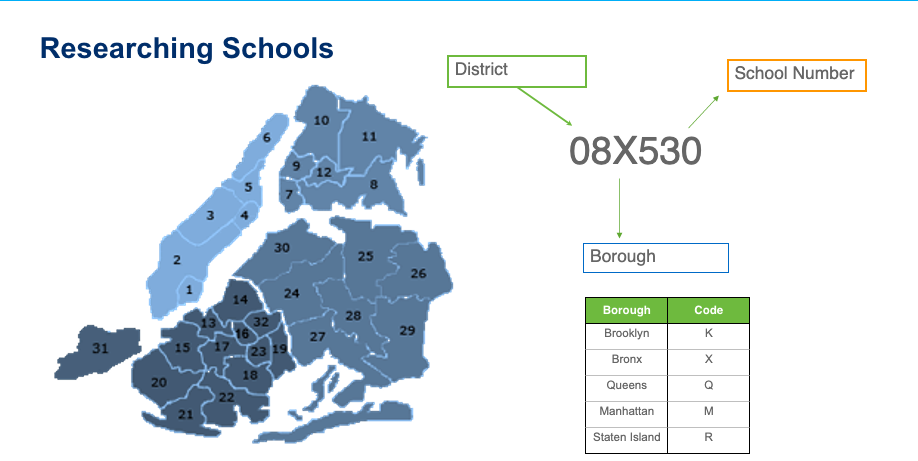

In [16]:
#split DBN into it's 3 components, creating column for each: District Number, Borough Code, School Number
attendance['District_Number'] = attendance.DBN.astype(str).str[:2]
attendance['Borough_Code'] = attendance.DBN.astype(str).str[2]
attendance['School_Number'] = attendance.DBN.astype(str).str[3:]
attendance.head()

DBN                School Name               Grade     Year  \
0  01M015  P.S. 015 Roberto Clemente          All Grades  2013-14   
1  01M015  P.S. 015 Roberto Clemente  PK in K-12 Schools  2013-14   
2  01M015  P.S. 015 Roberto Clemente                  0K  2013-14   
3  01M015  P.S. 015 Roberto Clemente                   1  2013-14   
4  01M015  P.S. 015 Roberto Clemente                   2  2013-14   

  Demographic Variable  # Days Absent  # Days Present  % Attendance  \
0         All Students         2783.0         32020.0          92.0   
1         All Students          560.0          4151.0          88.1   
2         All Students          659.0          6414.0          90.7   
3         All Students          525.0          6214.0          92.2   
4         All Students          308.0          3680.0          92.3   

   % Chronically Absent  Next Year % Chronically Absent  \
0                  26.9                            23.4   
1                  53.3                            65.2   
2                  29.5                            30.0   
3                  31.0                            18.8   
4                  20.0                            21.9   

  Chronically_Absent_Next_Year District_Number Borough_Code School_Number  
0                       Medium              01            M           015  
1                         High              01            M           015  
2                       Medium              01            M           015  
3                       Medium              01            M           015  
4                       Medium              01            M           015

In [17]:
#create more user friendly District Code column
def turn_friendly(code): 
  
    if code == 'K': 
        return "Brooklyn"
  
    elif code == 'X':
        return "Bronx"
    
    elif code == 'Q':
        return "Queens"
    
    elif code == 'M':
        return "Manhattan"
    
    elif code == 'R':
        return "Staten Island"
  
    else: 
        return "Error"

In [18]:
#passing function to apply and storing returned series as new column
attendance['Borough_Name'] = attendance['Borough_Code'].apply(turn_friendly) 
attendance.Borough_Name.value_counts()

Brooklyn         178769
Queens           148530
Bronx            133381
Manhattan        110824
Staten Island     31912
Name: Borough_Name, dtype: int64

### Quick EDA of new variables

In [19]:
def see_target_interactions(dataframe, target_variable):
    '''vizualize scatterplot to see interaction between target variable and each variable'''
    for col in dataframe.columns:
        sns.scatterplot(x=col, y=target_variable, data=dataframe)
        plt.show()

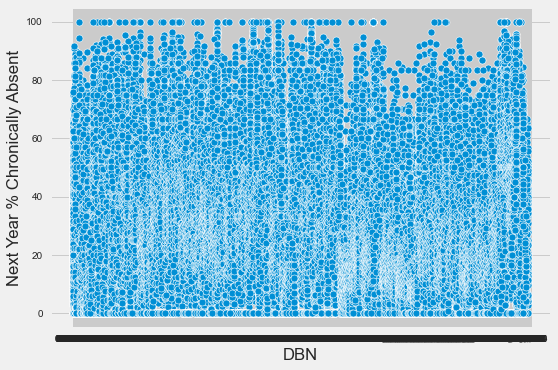

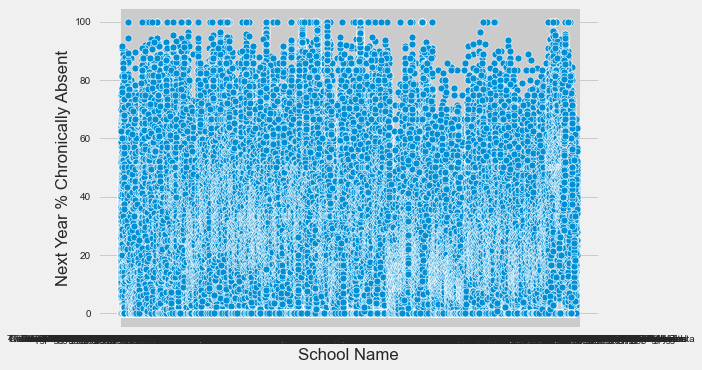

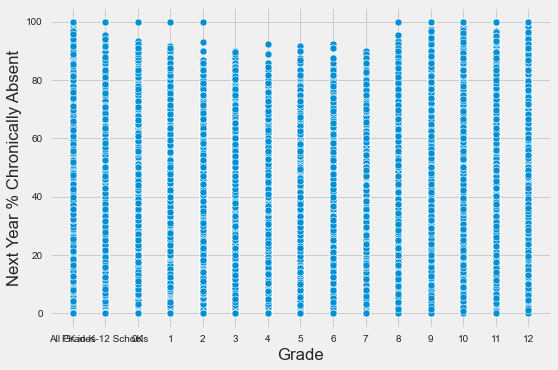

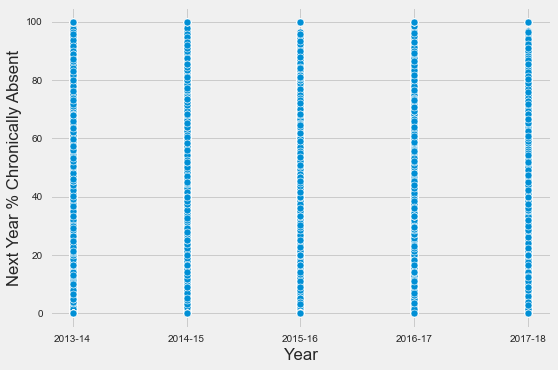

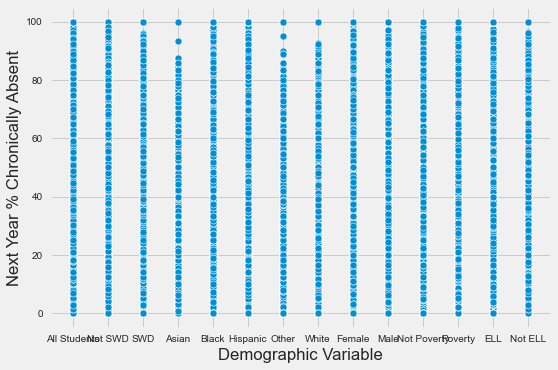

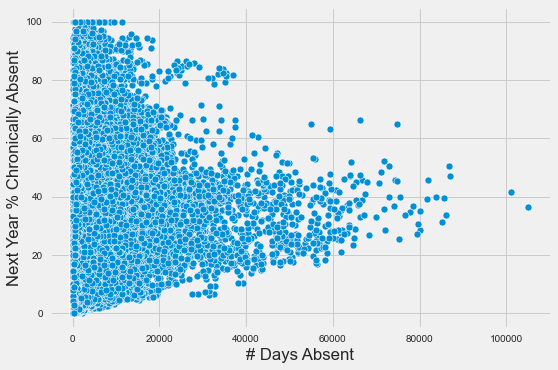

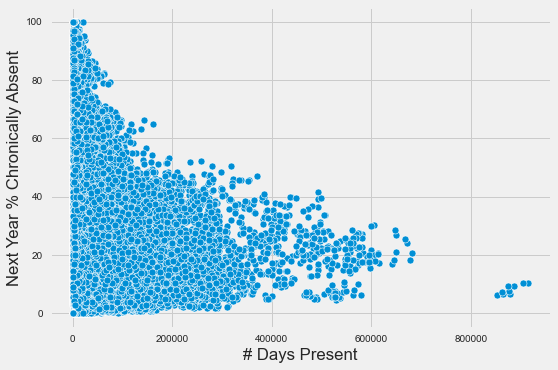

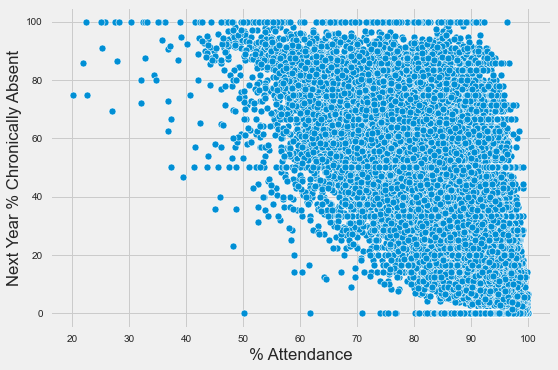

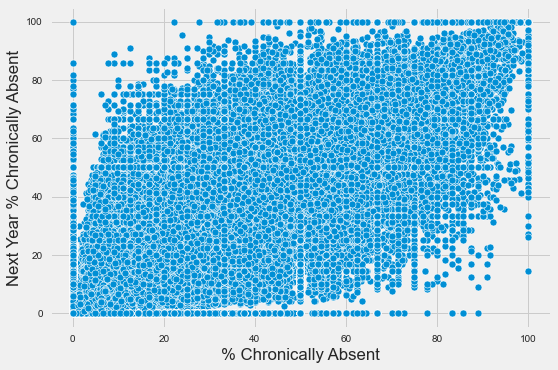

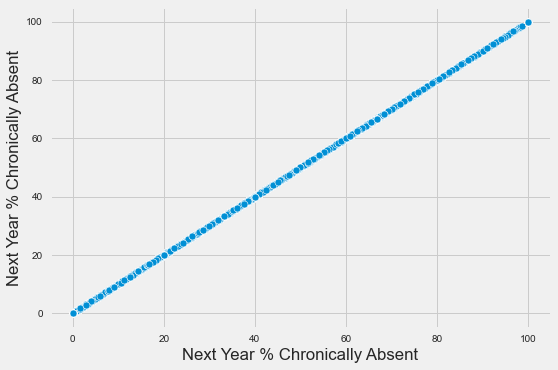

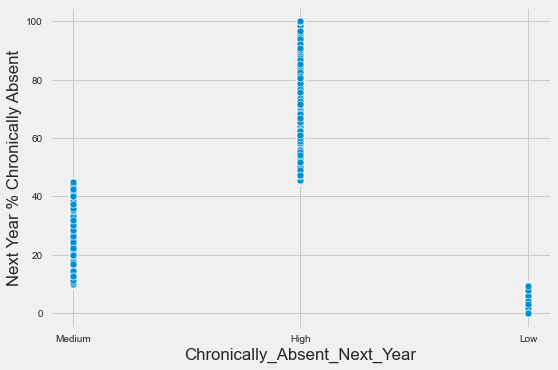

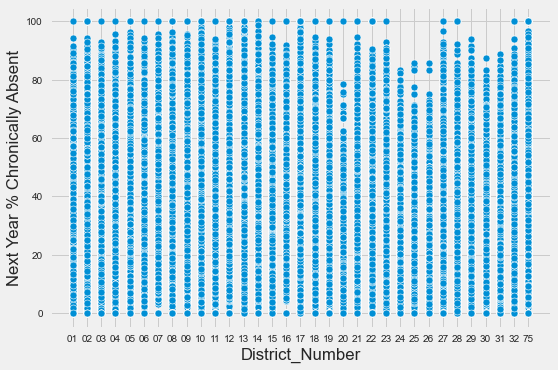

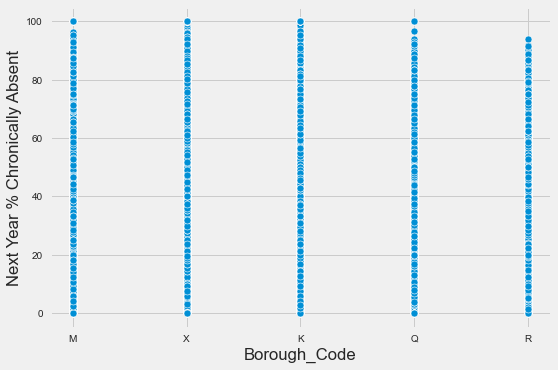

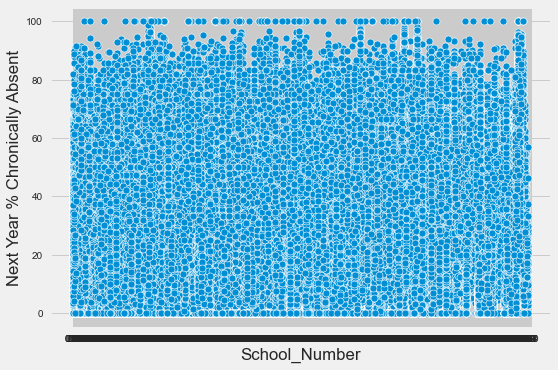

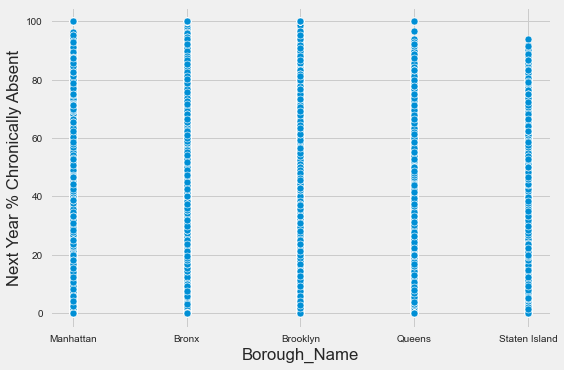

In [20]:
#get scatterplot for all interactions with target variable
see_target_interactions(attendance, 'Next Year % Chronically Absent')

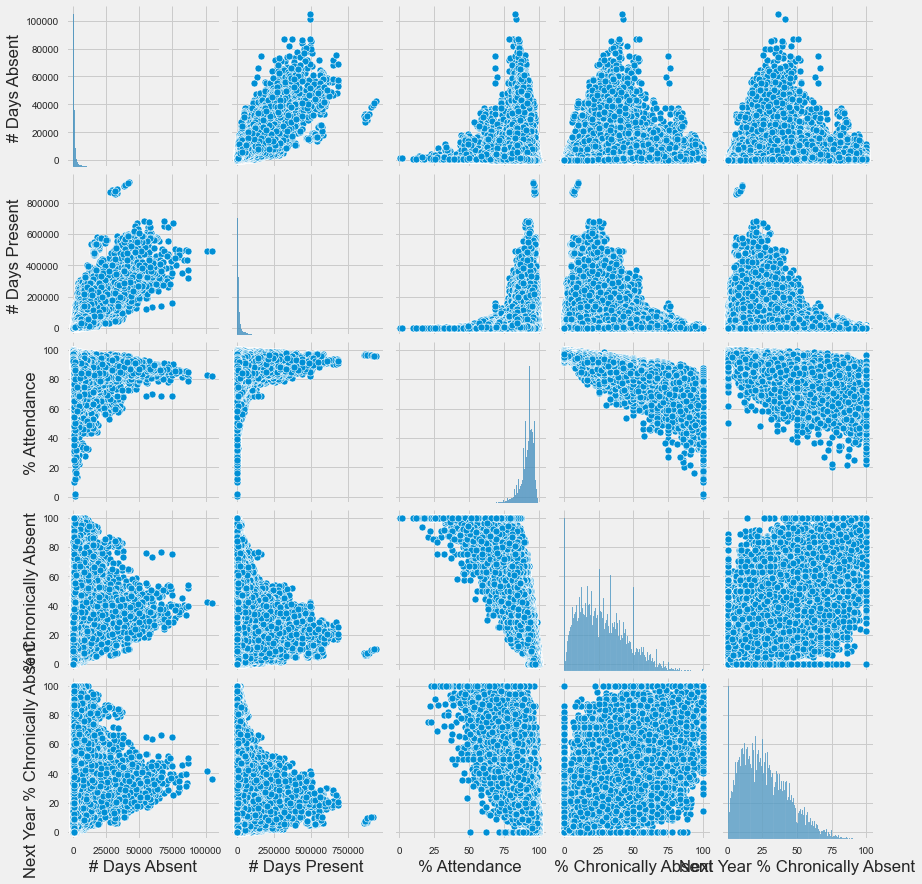

In [21]:
#scatter plot of each numeric variable with all other numeric variable 
sns.pairplot(attendance)

In [22]:
#build pandas profiling for quick EDA
profile = ProfileReport(attendance)
profile

In [23]:
#save pandas profiling report
os.chdir('/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/reports')
profile.to_file("notebook-1.2-attendance_EDA.html")

<AxesSubplot:xlabel='District_Number', ylabel='Next Year % Chronically Absent'>

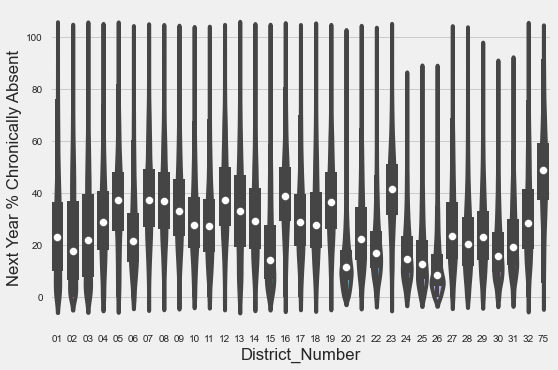

In [24]:
#MAKE VIOLIN PLOTS OF new CATEGORICAL VALUES VS TARGET VARIABLE 
#lots of variation by district
sns.violinplot(x='District_Number', y='Next Year % Chronically Absent', data=attendance)

<AxesSubplot:xlabel='Borough_Name', ylabel='Next Year % Chronically Absent'>

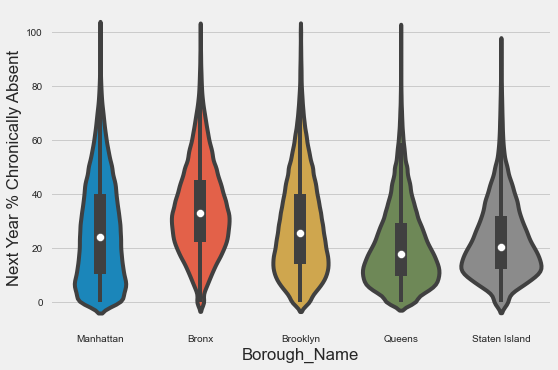

In [25]:
#Queens and Staten Island have the lowest rates of chronically absent students
#followed by Manhattan and then Brooklyn (have larger ranges than the others)
#Bronx has the highest, and seems to be more normally distributed than the others
sns.violinplot(x='Borough_Name', y='Next Year % Chronically Absent', data=attendance)

In [26]:
attendance.describe()

# Days Absent  # Days Present   % Attendance  % Chronically Absent  \
count  603416.000000   603416.000000  603416.000000         603416.000000   
mean     1495.260260    16902.322214      91.293766             27.720952   
std      2873.307826    30097.539480       5.341074             18.062075   
min         0.000000        8.000000       0.700000              0.000000   
25%       299.000000     3680.000000      89.400000             13.500000   
50%       647.000000     8017.000000      92.600000             25.000000   
75%      1425.000000    16040.250000      94.700000             39.400000   
max    105055.000000   934266.000000     100.000000            100.000000   

       Next Year % Chronically Absent  
count                   453956.000000  
mean                        27.376080  
std                         17.703096  
min                          0.000000  
25%                         13.300000  
50%                         25.000000  
75%                         38.900000  
max                        100.000000

### Feature Selection 

In [27]:
attendance.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '# Days Absent', '# Days Present', '% Attendance',
       '% Chronically Absent', 'Next Year % Chronically Absent',
       'Chronically_Absent_Next_Year', 'District_Number', 'Borough_Code',
       'School_Number', 'Borough_Name'],
      dtype='object')

In [28]:
#drop DBN, school name, and school number for dummy variables
attendance = attendance.drop(columns=['DBN', 'School Name', 'School_Number'])

#drop Borough Code/Name because it is highly correlated with District Number, and District Number has more info
#district Number also has more correlation with target variable
attendance = attendance.drop(columns=['Borough_Code', 'Borough_Name'])

#drop COLUMNS (# days absent, # days present) because ''% attendance' column has this info 
#and we don't have these variables in current daily data from NYC OpenData
attendance = attendance.drop(columns=['# Days Absent', '# Days Present'])

In [29]:
#separate 2018-2019 data from 2013-18 school years for later predicting
attendance_2018_19 = attendance[attendance.Year == '2018-19'].index
print(attendance.shape)
print(attendance_2018_19.shape)
attendance_2013_18 = attendance.drop(attendance_2018_19)
print(attendance_2013_18.shape)

(603416, 8)
(102645,)
(500771, 8)


In [79]:
attendance.dtypes

Grade                              object
Year                               object
Demographic Variable               object
% Attendance                      float64
% Chronically Absent              float64
Next Year % Chronically Absent    float64
Chronically_Absent_Next_Year       object
District_Number                    object
dtype: object

In [80]:
attendance['District_Number'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '75'],
      dtype=object)

In [72]:
#separate 2018-2019 data
attendance_2018_2019 = attendance[attendance.Year == '2018-19']
attendance_2018_2019

Grade     Year Demographic Variable  % Attendance  \
500771          All Grades  2018-19         All Students          92.6   
500772  PK in K-12 Schools  2018-19         All Students          88.4   
500773                  0K  2018-19         All Students          91.9   
500774                   1  2018-19         All Students          90.7   
500775                   2  2018-19         All Students          94.0   
...                    ...      ...                  ...           ...   
603411                  10  2018-19              Not ELL          84.2   
603412                  11  2018-19                  ELL          79.8   
603413                  11  2018-19              Not ELL          86.0   
603414                  12  2018-19                  ELL          80.6   
603415                  12  2018-19              Not ELL          84.4   

        % Chronically Absent  Next Year % Chronically Absent  \
500771                  24.2                             NaN   
500772                  50.0                             NaN   
500773                  28.6                             NaN   
500774                  28.6                             NaN   
500775                  11.8                             NaN   
...                      ...                             ...   
603411                  52.8                             NaN   
603412                  66.7                             NaN   
603413                  55.2                             NaN   
603414                  66.7                             NaN   
603415                  47.4                             NaN   

       Chronically_Absent_Next_Year District_Number  
500771                          NaN              01  
500772                          NaN              01  
500773                          NaN              01  
500774                          NaN              01  
500775                          NaN              01  
...                             ...             ...  
603411                          NaN              75  
603412                          NaN              75  
603413                          NaN              75  
603414                          NaN              75  
603415                          NaN              75  

[102645 rows x 8 columns]

In [30]:
#check if this was sucessful
attendance_2013_18.Year.value_counts()

2017-18    102496
2016-17    102411
2015-16    100911
2014-15     98739
2013-14     96214
Name: Year, dtype: int64

In [31]:
#check NaNs in resulting dataframe
NaNs_as_percent(attendance_2013_18)

Grade                             0.000000
Year                              0.000000
Demographic Variable              0.000000
% Attendance                      0.000000
% Chronically Absent              0.000000
Next Year % Chronically Absent    9.348584
Chronically_Absent_Next_Year      9.348584
District_Number                   0.000000
dtype: float64


In [32]:
#for now, will drop these NaNs until further research is conducted
attendance_2013_18 = attendance_2013_18.dropna()
NaNs_as_percent(attendance_2013_18)

Grade                             0.0
Year                              0.0
Demographic Variable              0.0
% Attendance                      0.0
% Chronically Absent              0.0
Next Year % Chronically Absent    0.0
Chronically_Absent_Next_Year      0.0
District_Number                   0.0
dtype: float64


In [33]:
#check dtypes
attendance_2013_18.dtypes

Grade                              object
Year                               object
Demographic Variable               object
% Attendance                      float64
% Chronically Absent              float64
Next Year % Chronically Absent    float64
Chronically_Absent_Next_Year       object
District_Number                    object
dtype: object

## Create dummy or indicator features for categorical variables

In [34]:
#create separate dataframes for regression vs. classification of target variable
attendance_2013_18_regressor = attendance_2013_18.drop(columns=['Chronically_Absent_Next_Year'])
attendance_2013_18_classifier = attendance_2013_18.drop(columns=['Next Year % Chronically Absent'])
print(attendance_2013_18_classifier.shape)
print(attendance_2013_18_regressor.shape)

(453956, 7)
(453956, 7)


In [35]:
#create dummy variables for the two data frames
dummy_attendance_2013_18_regressor = pd.get_dummies(attendance_2013_18_regressor)

#remove target variable from classification data, so it does not get turned into a dummy variable
dummy_attendance_2013_18_classifier = pd.get_dummies(attendance_2013_18_classifier.drop(columns=['Chronically_Absent_Next_Year']))

#save target variable for classification
target_classifier = attendance_2013_18['Chronically_Absent_Next_Year']

print(dummy_attendance_2013_18_classifier.shape)
print(dummy_attendance_2013_18_regressor.shape)

(453956, 69)
(453956, 70)


## Split into testing and training datasets

In [36]:
#define variables for regressor
X = dummy_attendance_2013_18_regressor.drop(columns=['Next Year % Chronically Absent'])
y = dummy_attendance_2013_18_regressor['Next Year % Chronically Absent']

In [37]:
#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [38]:
#check len of data with 80/20 split
len(attendance_2013_18_regressor) * .8, len(attendance_2013_18_regressor) * .2

(363164.80000000005, 90791.20000000001)

In [39]:
#check shape of variables
#different than what I excpted
X_train.shape, X_test.shape

((378297, 69), (75659, 69))

In [40]:
y_train.shape, y_test.shape

((378297,), (75659,))

In [41]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

% Attendance            float64
% Chronically Absent    float64
Grade_0K                  uint8
Grade_1                   uint8
Grade_10                  uint8
                         ...   
District_Number_29        uint8
District_Number_30        uint8
District_Number_31        uint8
District_Number_32        uint8
District_Number_75        uint8
Length: 69, dtype: object

In [42]:
#repeat for xtest
X_test.dtypes

% Attendance            float64
% Chronically Absent    float64
Grade_0K                  uint8
Grade_1                   uint8
Grade_10                  uint8
                         ...   
District_Number_29        uint8
District_Number_30        uint8
District_Number_31        uint8
District_Number_32        uint8
District_Number_75        uint8
Length: 69, dtype: object

## Standardize the magnitude of numeric features using a scaler

In [43]:
#not doing because don't need to scale the numeric variables (only go 0-100) or dummy variables

#PCA check/cluster schools? (LOOK AT GUIDED CAPSTONE EDA?)
#rememeber to note about outliers (see notes in 1.1 EDA notebook)

# Modeling

### Initial Benchmark - Dummy Regressor

In [44]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

27.31792586248235

In [45]:
#Fit the dummy regressor on the training data
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[27.31792586]])

In [46]:
#create dummy regressor predictions 
y_tr_pred = dumb_reg.predict(X_train)
#Make prediction with the single value of the (training) mean.
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0003902419452113115)

In [47]:
#establish baseline for mean absolute error and mean square error 
print('MAEs:', mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred))
print('MSEs:', mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred))

MAEs: 14.425187661095018 14.407710596424323
MSEs: 313.6617613921039 312.10496683625587


### Linear Regression Model

In [48]:
lm = LinearRegression().fit(X_train, y_train)

In [49]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [50]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.7033726928662727, 0.6741869544615983)


In [51]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (7.033257721890469, 7.3697038978164535)


In [52]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse)

mse: (93.0406436325615, 101.64820238035826)


In [53]:
#try cross validation, results may be innacurate due to time series split..
cv_results = cross_validate(LinearRegression(), X_train, y_train, cv=5)

In [54]:
cv_scores = cv_results['test_score']
cv_scores

array([ 7.19282969e-01,  7.02694889e-01,  6.98377976e-01,  6.94595518e-01,
       -2.42399082e+18])

In [55]:
np.mean(cv_scores), np.std(cv_scores)

(-4.847981633603145e+17, 9.69596326720629e+17)

In [56]:
#hyperparameter tuning

In [57]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

## Initial Classification Models

In [58]:
#define variables for classifier
X_c = dummy_attendance_2013_18_classifier
y_c = target_classifier

In [59]:
# dividing X_c, y_c into train and test data 
#X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, random_state = 0) 

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

### Decision Tree

In [60]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [61]:
print(dtree_model.score(X_test, y_test))
print(cm)

0.7752944130903131
[[ 6442    29  6698]
 [   23  7650  4478]
 [ 2087  3686 44566]]


In [77]:
print(classification_report(y_test, dtree_predictions))

              precision    recall  f1-score   support

        High       0.75      0.49      0.59     13169
         Low       0.67      0.63      0.65     12151
      Medium       0.80      0.89      0.84     50339

    accuracy                           0.78     75659
   macro avg       0.74      0.67      0.69     75659
weighted avg       0.77      0.78      0.77     75659



### K-Nearest Neighbors

In [62]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [63]:
# Predict the labels for the training data X
y_pred = knn.predict(X_test)

In [64]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7748185939544535


In [65]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 8049    33  5087]
 [   47  7204  4900]
 [ 3674  3296 43369]]
              precision    recall  f1-score   support

        High       0.68      0.61      0.65     13169
         Low       0.68      0.59      0.64     12151
      Medium       0.81      0.86      0.84     50339

    accuracy                           0.77     75659
   macro avg       0.73      0.69      0.71     75659
weighted avg       0.77      0.77      0.77     75659



### Saved processed data

In [75]:
#save data sets 
attendance_2013_18_regressor.to_csv(r'/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed/attendance_2013_18_regressor.csv', index=False)
attendance_2013_18_classifier.to_csv(r'/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed/attendance_2013_18_classifier.csv', index=False)

In [76]:
#save 2018-2019 data 
#need to make drop either of the two categorical variables and then create dummy variables
attendance_2018_2019.to_csv(r'/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed/attendance_2018_19.csv', index=False)

## Notes /Summary

In [ ]:
#don't drop school name, DBN etc. till after train/test split (see below)
#you can save these variables to add in later..

#Save the 'Name', 'state', and 'Region' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ['Name', 'state', 'Region']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

In [ ]:
#THINK ABOUT later model...
    #??need to drop %Chronically Absent??

#four point difference in R2 score when `% Chronically Absent` is dropped - from .67 to .63 
#0.6 point difference in MAE from 7.4 to 8 
#11.4 point difference in MSE from 101.6 to 113

**NEED TO FIGURE THIS OUT, IT IS 9% of DATA!!**

It seems that the NaNs in Next Year % Chronically Absent aren't just in 2018-19 as expected. There are around 6% of data each year that does not have next year's data. Some of the schools I looked into were closed or had name changes. This could possibly be due to inconsistent naming of the schools year to year led to a calculation error for Next Year % Chronically Absent or these school did not have data for that subset of students the following year. I will have to dig further into why this may be occuring. This makes up around 7.8% of data.

In [ ]:
#DISTRICT NUMBER AND BOROUGH CODE HIGHLLY CORRELATED, TRY BOTH SEPARATELY TO SEE WHICH IS BETTER FOR MODELING 
# (ie. use borough code for more generalizable model) --> try in later model

In [ ]:
#USE HUE to get line plot of %chronically absent by different categorical variables (in EDA)
sns.lineplot(data=df_daily, x="login_time", y="count", hue="day_of_week")

STEPS Remaining: **MOVE TO NOTES FOR FUTURE THINGS TO TRY**
    - ?go back (WRANGLE) and deal with outliers (drop them)
    - ?go back and do EDA to scale data and do PCA to see which features I should preserve?)
    - x#MAKE VIOLIN PLOTS OF ALL CATEGORICAL VALUES VS TARGET VARIABLE 
        - x#DISTRICT NUMBER AND BOROUGH CODE HIGHLLY CORRELATED, TRY BOTH SEPARATELY TO SEE WHICH IS BETTER FOR MODELING
        - xfor model, prob drop borough code as district number has this info and has higher correlation with target variable
    - ?scale data 
        - xconsider dropping # days absent, # days present because % attendance has this number and we don't have these variables in current daily data. THEN WE DONT SCALE THE DATA (or drop outliers..)...